In [1]:
import geopandas as gpd
import pandas as pd
import asf_search as asf
from shapely.geometry import Polygon, shape
import datetime
from tqdm import tqdm
from rasterio.crs import CRS
import warnings
from datetime import timezone
import matplotlib.pyplot as plt

In [2]:
df_planet = gpd.read_file('s3://opera-calval-database-dswx/image.geojson')
df_planet = df_planet[['site_name', 'image_name', 'datetime']]
df_planet.head()

,site_name,image_name,datetime
0,3_38,20210929_212809_16_2442,2021-09-29 21:28:09
1,4_43,20210927_095537_0f15,2021-09-27 09:55:37
2,3_1,20210925_072712_16_2254,2021-09-25 07:27:12
3,4_34,20210901_175205_71_2426,2021-09-01 17:52:05
4,3_30,20210911_005129_82_106a,2021-09-11 00:51:29


In [3]:
def get_finalized_validation_datasets() -> gpd.GeoDataFrame:
    df_image_calc = gpd.read_file('s3://opera-calval-database-dswx/image_calc.geojson')

    #  Group by upload date and image name and get the most recent
    df_image_calc = df_image_calc.sort_values(by=['image_name', 'upload_date'], ascending=True)
    df_image_calc = df_image_calc.groupby('image_name').tail(1)

    # Check if "final" is in processing level
    df_image_calc.dropna(subset=['processing_level'], inplace=True)
    temp = df_image_calc.processing_level.str.lower()
    df_image_calc = df_image_calc[temp.str.contains('final')].reset_index(drop=True)
    return df_image_calc

In [4]:
df_val = get_finalized_validation_datasets()
df_val.head()

,bucket,calc_type,calculated_by,image_calc_name,image_name,notes,oversight_level,previous_name,processing_level,public,reviewed_by,s3_keys,upload_date,version,water_strata,water_stratum,geometry
0,opera-calval-database-dswx,Review,Charlie Marshak,20210903_150800_60_2458_classification_v2,20210903_150800_60_2458,Previous(Previous((CM): Used a NDWI threshold ...,None,20210903_150800_60_2458_classification_v1,Final,True,Alexander Handwerger,data/site/4_21/image/20210903_150800_60_2458/i...,20220930_152559,2.0,NaN,3.0,"POLYGON ((-71.87051 55.11002, -71.87051 55.166..."
1,opera-calval-database-dswx,Review,Charlie Marshak,20210903_152641_60_105c_classification_v2,20210903_152641_60_105c,Previous(This is water with lots of boalders p...,None,20210903_152641_60_105c_classification_v1.0,Final,True,Matthew Bonnema,data/site/4_11/image/20210903_152641_60_105c/i...,20221019_151359,2.0,NaN,3.0,"POLYGON ((-69.17307 54.40592, -69.17307 54.460..."
2,opera-calval-database-dswx,Review,Matthew Bonnema,20210904_093422_44_1065_classification_v1,20210904_093422_44_1065,Previous(Only water is a small pond near cente...,None,20210904_093422_44_1065_classification_v0,Final,True,Simran Sangha,data/site/1_31/image/20210904_093422_44_1065/i...,20221028_164450,1.0,NaN,1.0,"POLYGON ((17.28244 -29.97141, 17.28244 -29.916..."
3,opera-calval-database-dswx,Review,Alexander Handwerger,20210906_101112_28_225a_classification_v1,20210906_101112_28_225a,Previous(Supervised Classification using Semia...,None,20210906_101112_28_225a_classification_v0,Final,True,Charlie Marshak,data/site/3_28/image/20210906_101112_28_225a/i...,20220929_144718,1.0,NaN,2.0,"POLYGON ((-0.04389 43.05233, -0.04389 43.16776..."
4,opera-calval-database-dswx,Review,Charlie Marshak,20210909_000649_94_222b_classification_v1,20210909_000649_94_222b,Previous((CM): Looked at RGB and false color b...,None,20210909_000649_94_222b_classification_v0,Final,True,Alexander Handwerger,data/site/1_37/image/20210909_000649_94_222b/i...,20221027_162451,1.0,NaN,1.0,"POLYGON ((138.25959 -30.32811, 138.25959 -30.2..."


In [5]:
df = pd.merge(df_val[['image_name', 'geometry']], df_planet, on='image_name', how='left')
df.head()

,image_name,geometry,site_name,datetime
0,20210903_150800_60_2458,"POLYGON ((-71.87051 55.11002, -71.87051 55.166...",4_21,2021-09-03 15:08:00
1,20210903_152641_60_105c,"POLYGON ((-69.17307 54.40592, -69.17307 54.460...",4_11,2021-09-03 15:26:41
2,20210904_093422_44_1065,"POLYGON ((17.28244 -29.97141, 17.28244 -29.916...",1_31,2021-09-04 09:34:22
3,20210906_101112_28_225a,"POLYGON ((-0.04389 43.05233, -0.04389 43.16776...",3_28,2021-09-06 10:11:12
4,20210909_000649_94_222b,"POLYGON ((138.25959 -30.32811, 138.25959 -30.2...",1_37,2021-09-09 00:06:49


In [6]:
def get_results_and_format(validation_footprint: Polygon, 
                           validation_date_acq: datetime.datetime,
                           image_name: str,
                           window_days: int = 12):
    
    validation_date_acq = validation_date_acq.replace(tzinfo=timezone.utc)
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=validation_footprint.wkt,
                         maxResults=100,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=(validation_date_acq - datetime.timedelta(days=window_days)),
                         end=(validation_date_acq + datetime.timedelta(days=window_days))
                         )
    
    geometry = [shape(r.geojson()['geometry']) for r in res]
    data = [r.properties for r in res]

    df_res = pd.DataFrame(data)
    df_res = gpd.GeoDataFrame(df_res,
                              geometry=geometry,
                              crs=CRS.from_epsg(4326))
    if not df_res.empty:
        df_res['image_name'] = image_name
        df_res['startTime'] = pd.to_datetime(df_res['startTime'])
        
        df_res.sort_values(by=['pathNumber','startTime'], inplace=True)
        julian_dates = df_res.startTime.map(lambda dt: dt.to_julian_date())
        ## Note this calculus depends on the repeat pass frequency of Sentinel-1 which is 6
        df_res['repeat_pass_id'] = ((julian_dates - julian_dates[0]) // 5).astype(int)
        df_res = df_res.dissolve(by=['repeat_pass_id', 'pathNumber'], aggfunc='first').reset_index(drop=False)
        
        total_seconds = (df_res['startTime'] - validation_date_acq).dt.total_seconds()
        df_res['acq_delta_hours'] = total_seconds / (60**2)
        df_res['acq_delta_days'] = df_res['acq_delta_hours'] / 24
        df_res['acq_delta_hours_abs'] = df_res['acq_delta_hours'].abs()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            overlap_area = df_res['geometry'].intersection(validation_footprint).area
            df_res['overlap_percentage'] = (overlap_area / validation_footprint.area ) * 100
        df_res.sort_values(by=['acq_delta_hours_abs', 'overlap_percentage'], inplace=True)
        df_res = df_res.reset_index(drop=True)
    return df_res

## Single Thread

In [7]:
# dfs_results = [get_results_and_format(data['geometry'], 
#                                       data['datetime'],
#                                       data['image_name']) for _, data in tqdm(list(df.iterrows()))]

## Multithreaded

In [8]:
import concurrent.futures

_, data_dicts = zip(*list(df.iterrows()))

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    dfs = list(tqdm(executor.map(lambda data: get_results_and_format(data['geometry'], 
                                                                     data['datetime'],
                                                                     data['image_name']), 
                                 data_dicts), 
                    total=len(data_dicts)))

100%|█| 52/52 [00:17<00:00,  2.90it/


In [9]:
dfs[0].columns

Index(['repeat_pass_id', 'pathNumber', 'geometry', 'beamModeType', 'browse',
       'bytes', 'centerLat', 'centerLon', 'faradayRotation', 'fileID',
       'flightDirection', 'groupID', 'granuleType', 'insarStackId', 'md5sum',
       'offNadirAngle', 'orbit', 'platform', 'pointingAngle', 'polarization',
       'processingDate', 'processingLevel', 'sceneName', 'sensor', 'startTime',
       'stopTime', 'url', 'fileName', 'frameNumber', 'image_name',
       'acq_delta_hours', 'acq_delta_days', 'acq_delta_hours_abs',
       'overlap_percentage'],
      dtype='object')

In [10]:
df_s1 = pd.concat(dfs, axis=0).reset_index(drop=True)

In [12]:
df_s1.head()

,repeat_pass_id,pathNumber,geometry,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,...,startTime,stopTime,url,fileName,frameNumber,image_name,acq_delta_hours,acq_delta_days,acq_delta_hours_abs,overlap_percentage
0,-3.0,62.0,"POLYGON ((-75.86066 56.10256, -75.25719 54.489...",IW,None,4.415156e+09,55.5183,-73.5570,None,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...,...,2021-09-02 22:38:54+00:00,2021-09-02T22:39:21.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...,178.0,20210903_150800_60_2458,-16.485000,-0.686875,16.485000,100.0
1,-2.0,164.0,"POLYGON ((-73.69633 55.83367, -73.09887 54.220...",IW,None,4.468483e+09,55.2486,-71.4099,None,S1A_IW_SLC__1SDV_20210909T223036_20210909T2231...,...,2021-09-09 22:30:36+00:00,2021-09-09T22:31:03.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210909T223036_20210909T2231...,177.0,20210903_150800_60_2458,151.376667,6.307361,151.376667,100.0
2,0.0,62.0,"POLYGON ((-75.86159 56.10360, -75.25812 54.490...",IW,None,4.371264e+09,55.5194,-73.5579,None,S1A_IW_SLC__1SDV_20210914T223854_20210914T2239...,...,2021-09-14 22:38:54+00:00,2021-09-14T22:39:21.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210914T223854_20210914T2239...,178.0,20210903_150800_60_2458,271.515000,11.313125,271.515000,100.0
3,-2.0,91.0,"POLYGON ((-71.49984 55.57276, -67.49414 55.979...",IW,None,4.398229e+09,54.9875,-69.2501,None,S1A_IW_SLC__1SDV_20210904T222218_20210904T2222...,...,2021-09-04 22:22:18+00:00,2021-09-04T22:22:45.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210904T222218_20210904T2222...,176.0,20210903_152641_60_105c,30.926944,1.288623,30.926944,100.0
4,0.0,164.0,"POLYGON ((-73.14349 54.35510, -69.22349 54.762...",IW,None,4.611322e+09,53.7404,-70.9362,None,S1A_IW_SLC__1SDV_20210909T223010_20210909T2230...,...,2021-09-09 22:30:10+00:00,2021-09-09T22:30:38.000Z,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,S1A_IW_SLC__1SDV_20210909T223010_20210909T2230...,172.0,20210903_152641_60_105c,151.058056,6.294086,151.058056,100.0


In [13]:
df_s1_first = df_s1.groupby(['image_name'])[['acq_delta_days','overlap_percentage', 'geometry', 'pathNumber', 'fileID']].first()
df_s1_first = gpd.GeoDataFrame(df_s1_first, geometry=df_s1_first.geometry, crs=CRS.from_epsg(4326))
df_s1_first

,acq_delta_days,overlap_percentage,geometry,pathNumber,fileID
image_name,,,,,
20210903_150800_60_2458,-0.686875,100.000000,"POLYGON ((-75.86066 56.10256, -75.25719 54.489...",62.0,S1A_IW_SLC__1SDV_20210902T223854_20210902T2239...
20210903_152641_60_105c,1.288623,100.000000,"POLYGON ((-71.49984 55.57276, -67.49414 55.979...",91.0,S1A_IW_SLC__1SDV_20210904T222218_20210904T2222...
20210904_093422_44_1065,3.328356,100.000000,"POLYGON ((16.88950 -29.53718, 17.36622 -31.148...",131.0,S1A_IW_SLC__1SDV_20210907T172712_20210907T1727...
20210906_101112_28_225a,-0.173669,27.410647,"POLYGON ((2.83995 41.96796, 3.27180 43.58648, ...",110.0,S1A_IW_SLC__1SDV_20210906T060107_20210906T0601...
20210909_000649_94_222b,-0.168854,100.000000,"POLYGON ((140.14239 -31.87752, 140.65891 -30.1...",60.0,S1B_IW_SLC__1SDV_20210908T200340_20210908T2004...
20210911_001230_44_2262,-2.173090,100.000000,"POLYGON ((140.14239 -31.87752, 137.54434 -31.2...",60.0,S1B_IW_SLC__1SDV_20210908T200315_20210908T2003...
20210911_005129_82_106a,-4.137581,100.000000,"POLYGON ((134.49429 60.29537, 135.26209 61.893...",32.0,S1B_IW_SLC__1SDV_20210906T213322_20210906T2133...
20210912_034049_22_2421,-2.167072,100.000000,"POLYGON ((99.07894 47.99276, 99.56930 49.60566...",77.0,S1B_IW_SLC__1SDV_20210909T234014_20210909T2340...
20210912_094213_84_240f,2.325625,100.000000,"POLYGON ((8.78768 14.38102, 9.12301 12.75160, ...",59.0,S1A_IW_SLC__1SDV_20210914T173107_20210914T1731...


# Visualize

<AxesSubplot: >

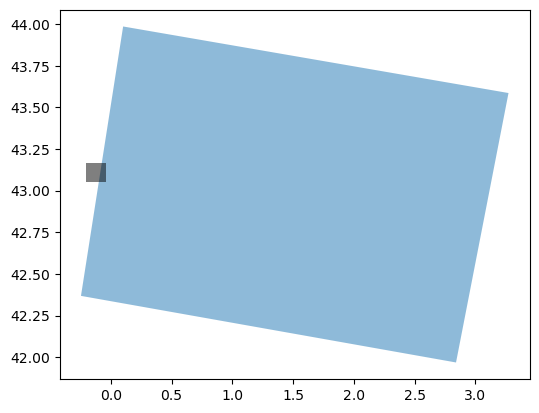

In [16]:
IMAGE_NAME = '20210906_101112_28_225a'

fig, ax = plt.subplots()

df_s1_first[df_s1_first.index == IMAGE_NAME].plot(ax=ax, alpha=.5)
df[df.image_name == IMAGE_NAME].plot(ax=ax, color='black', alpha=.5)

<AxesSubplot: >

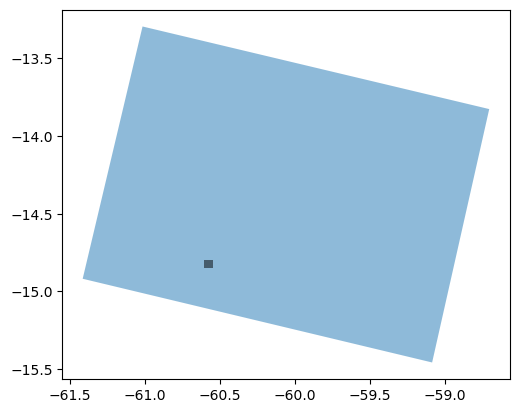

In [17]:
IMAGE_NAME = '20210928_141837_16_2407'

fig, ax = plt.subplots()

df_s1_first[df_s1_first.index == IMAGE_NAME].plot(ax=ax, alpha=.5)
df[df.image_name == IMAGE_NAME].plot(ax=ax, color='black', alpha=.5)